/home/george/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


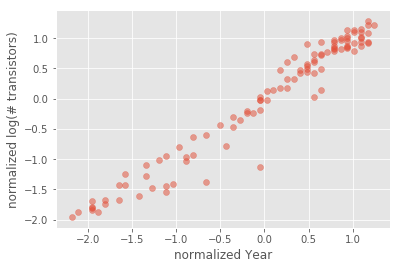

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pystan
import re
from sklearn.utils import shuffle
from sklearn import preprocessing
import pymc

%matplotlib inline  
plt.style.use('ggplot')

# Load and preprocess data
X = []
Y = []

non_decimal = re.compile(r'[^\d]+')

for line in open('moore.csv'):
    r = line.split('\t')
    x = int(non_decimal.sub('', r[2].split('[')[0]))
    y = int(non_decimal.sub('', r[1].split('[')[0]))
    X.append(x)
    Y.append(y)

X = np.array(X)
Y = np.array(Y)
X, Y = shuffle(X, Y, random_state=0)
X.shape = (X.shape[0], 1)
X = preprocessing.scale(X)
Y = preprocessing.scale(np.log(Y))

# split data into training and test set
N, M = X.shape
idx = int(0.8*N)
X_train = X[:idx, :]
Y_train = Y[:idx]
N_train = idx
X_test = X[idx:, :]
Y_test = Y[idx:]
N_test = N - N_train

plt.scatter(X, Y, alpha=0.5)
plt.xlabel('normalized Year')
plt.ylabel('normalized log(# transistors)')

In [6]:
# Pystan model for Ridge Regression

ridge_code = """

data {
    int<lower=0> M; // number of predictors
    int<lower=0> N_train; // number of observations on training
    matrix[N_train, M] X_train; // predictors matrix for training
    vector[N_train] Y_train; // response vector for training
    int<lower=0> N_test; // number of observations on test
    matrix[N_test, M] X_test; // predictors matrix for test
}


parameters {
    real intercept;
    vector[M] beta;
    real<lower=0> sigma;
}

model {
    vector[N_train] Y_mean;

    // Linear model
    Y_mean = X_train*beta + intercept;
    
    // Likelihood
    Y_train ~ normal(Y_mean, sigma);    
    
    // Priors
    intercept ~ normal(0, 10);
    beta ~ normal(0, 10);
    sigma ~ cauchy(0, 10);
}

generated quantities {
    vector[N_test] Y_pred;
    vector[N_test] Y_pred_mean;
    
    Y_pred_mean = X_test*beta + intercept;
    for (i in 1:N_test)
        Y_pred[i] = normal_rng(Y_pred_mean[i], sigma); //the y values predicted by the model
}
"""

# dictionary containing data
data = {
    'X_train': X_test,
    'Y_train': Y_test,
    'N_train': N_test,
    'X_test': X_test,
    'N_test': N_test,
    'M': M
}

# fit model
fit = pystan.stan(model_code=ridge_code, data=data, iter=2000, chains=4)
print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bbfb9babdab916a3f163d4c4021fa45c NOW.


Inference for Stan model: anon_model_bbfb9babdab916a3f163d4c4021fa45c.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
intercept        -0.06  1.2e-3   0.07   -0.2  -0.11  -0.06  -0.01   0.09   4000    1.0
beta[0]           0.97  1.5e-3   0.09    0.8   0.92   0.97   1.03   1.14   3148    1.0
sigma             0.32  1.0e-3   0.06   0.24   0.28   0.32   0.36   0.46   3058    1.0
Y_pred[0]        -0.85  5.9e-3   0.35  -1.54  -1.09  -0.85  -0.62  -0.15   3634    1.0
Y_pred[1]        -0.12  5.3e-3   0.33  -0.79  -0.33  -0.12   0.11   0.56   3951    1.0
Y_pred[2]         0.85  5.4e-3   0.34   0.18   0.63   0.85   1.08   1.55   4000    1.0
Y_pred[3]         0.11  5.3e-3   0.34  -0.56  -0.11   0.11   0.33   0.76   3987    1.0
Y_pred[4]        -0.11  5.5e-3   0.35  -0.79  -0.33  -0.11   0.12   0.57   4000    1.0
Y_pred[5]         0.56  5.3e

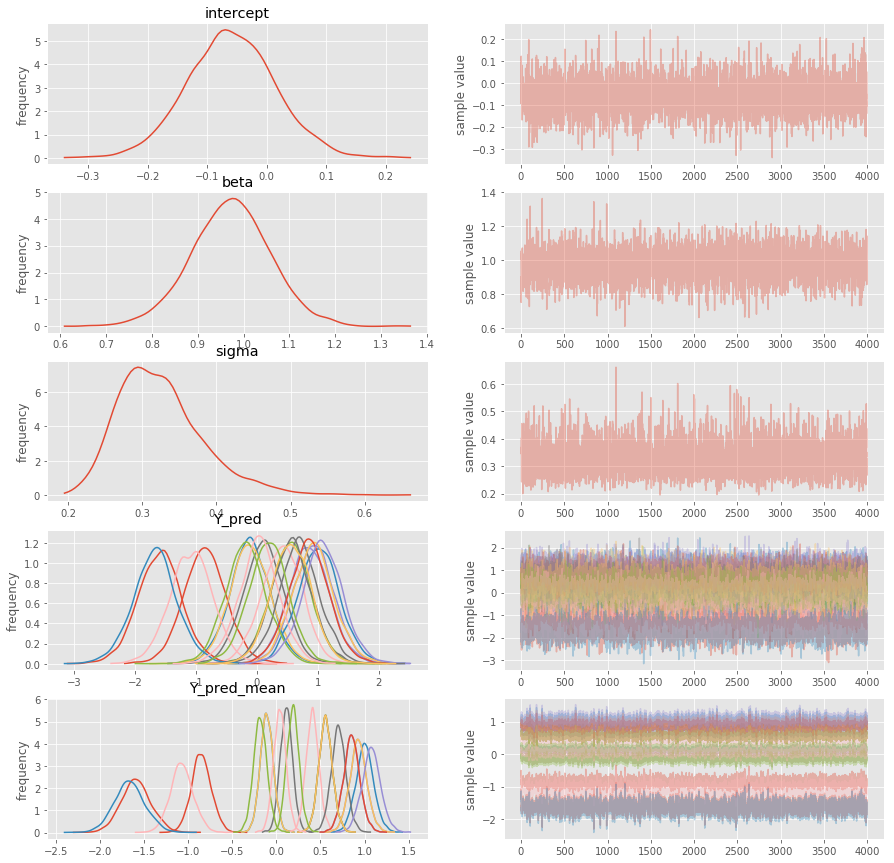

In [8]:
fig = fit.plot()
fig.set_size_inches(15, 15)

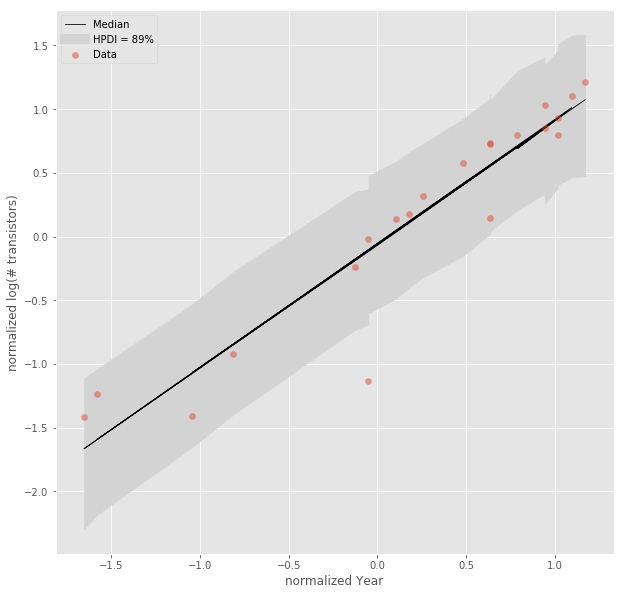

In [9]:
Y_pred = fit.extract('Y_pred')['Y_pred']
Y_hpdi = pymc.utils.hpd(Y_pred, 0.11)
Y_lower = Y_hpdi[0, :]
Y_upper = Y_hpdi[1, :]

fig, ax = plt.subplots(1)
fig.set_size_inches(10, 10)
ax.plot(X_test, np.median(Y_pred, axis=0), linewidth=0.8, color='k', label='Median', zorder=2)
ax.scatter(X_test, Y_test, alpha=0.5, label='Data', zorder=3)
sorted_x = X_test[:, 0].argsort()
Y_upper = Y_upper[sorted_x]
Y_lower = Y_lower[sorted_x]
X_test_sorted = X_test[sorted_x, :]
ax.fill_between(X_test_sorted[:, 0], Y_upper, Y_lower, color='lightgrey')
ax.plot([], [], color='lightgrey', label='HPDI = 89%', linewidth=10)
ax.legend(loc='upper left')
plt.xlabel('normalized Year')
plt.ylabel('normalized log(# transistors)')